In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [7]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)



228827136/228813984 [==============================] - 5s 0us/step


In [10]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


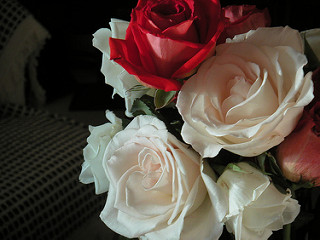

In [18]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

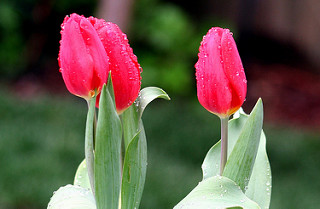

In [19]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [20]:
# dataset 만들기 

batch_size = 32 
img_height = 180 
img_width = 180

In [23]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir, 
                                                               validation_split=0.2,
                                                               subset='training',
                                                               seed=123,
                                                               image_size = (img_height, img_width),
                                                               batch_size=batch_size)
                                                        
                                                               

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [33]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


In [24]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [25]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


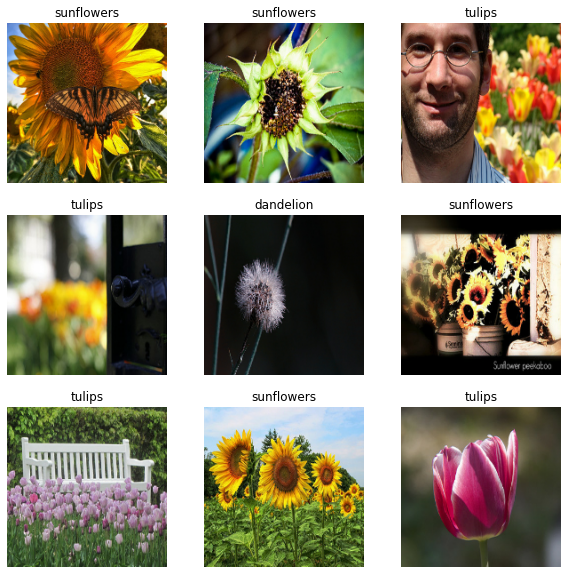

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1) : 
    for i in range(9) : 
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [32]:
for image_batch , labels_batch in train_ds : 
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [34]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [39]:
normalized_ds = train_ds.map(lambda x, y : (normalization_layer(x), y ))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


In [42]:
# create model 

num_classes = 5 

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3 , padding='same' , activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(32, 3 , padding='same' , activation='relu'),
    layers.MaxPool2D(),
    layers.Conv2D(64, 3 , padding='same' , activation='relu'),
    layers.MaxPool2D(),
    
    layers.Flatten(),
    layers.Dense(128, activation= 'relu') , 
    layers.Dense(num_classes)
])

In [44]:
# model compile 

model.compile(optimizer='adam' , 
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics = ['accuracy'])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

In [46]:
# model train 

epochs = 10 
history = model.fit(train_ds,
                   validation_data=val_ds,
                   epochs=epochs)

Epoch 1/10
92/92 [==============================] - 11s 47ms/step - loss: 1.2807 - accuracy: 0.4574 - val_loss: 1.0860 - val_accuracy: 0.5463
Epoch 2/10
92/92 [==============================] - 3s 29ms/step - loss: 0.9442 - accuracy: 0.6264 - val_loss: 0.9200 - val_accuracy: 0.6185
Epoch 3/10
92/92 [==============================] - 3s 30ms/step - loss: 0.7407 - accuracy: 0.7248 - val_loss: 0.9875 - val_accuracy: 0.6144
Epoch 4/10
92/92 [==============================] - 3s 29ms/step - loss: 0.5241 - accuracy: 0.8144 - val_loss: 0.9524 - val_accuracy: 0.6308
Epoch 5/10
92/92 [==============================] - 3s 29ms/step - loss: 0.2981 - accuracy: 0.9036 - val_loss: 1.1661 - val_accuracy: 0.6213
Epoch 6/10
92/92 [==============================] - 3s 30ms/step - loss: 0.1727 - accuracy: 0.9452 - val_loss: 1.3550 - val_accuracy: 0.6267
Epoch 7/10
92/92 [==============================] - 3s 30ms/step - loss: 0.0868 - accuracy: 0.9779 - val_loss: 1.5088 - val_accuracy: 0.6362
Epoch 8/10
9

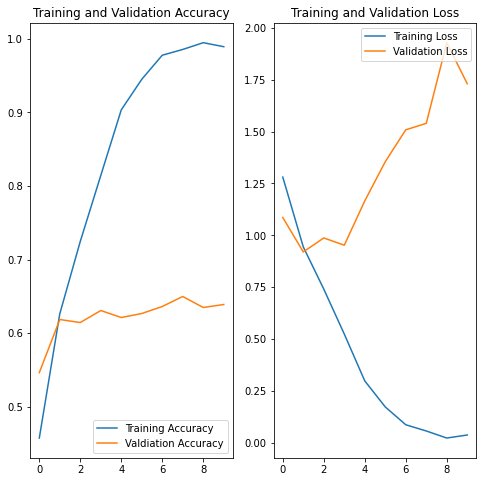

In [52]:
# 훈련결과 시각화 


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Valdiation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [53]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

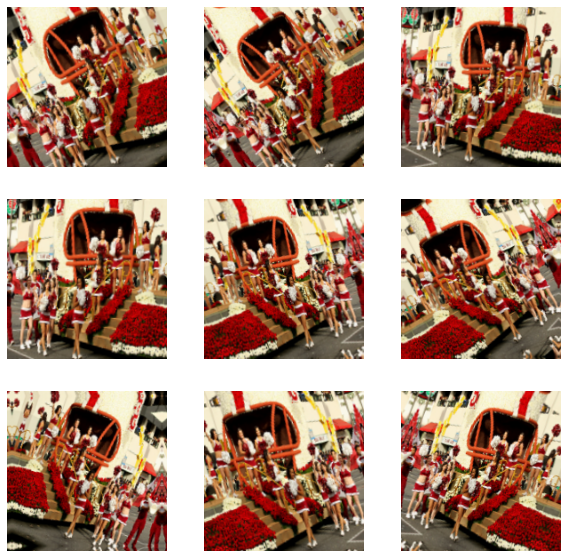

In [54]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [56]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [57]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [58]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 4s 39ms/step - loss: 1.4646 - accuracy: 0.3913 - val_loss: 1.1243 - val_accuracy: 0.5504
Epoch 2/15
92/92 [==============================] - 3s 36ms/step - loss: 1.0994 - accuracy: 0.5484 - val_loss: 1.0055 - val_accuracy: 0.6035
Epoch 3/15
92/92 [==============================] - 3s 36ms/step - loss: 0.9785 - accuracy: 0.6168 - val_loss: 0.9421 - val_accuracy: 0.6349
Epoch 4/15
92/92 [==============================] - 3s 36ms/step - loss: 0.9030 - accuracy: 0.6536 - val_loss: 0.8985 - val_accuracy: 0.6499
Epoch 5/15
92/92 [==============================] - 3s 36ms/step - loss: 0.8514 - accuracy: 0.6764 - val_loss: 0.9503 - val_accuracy: 0.6185
Epoch 6/15
92/92 [==============================] - 3s 36ms/step - loss: 0.8168 - accuracy: 0.6815 - val_loss: 0.8498 - val_accuracy: 0.6635
Epoch 7/15
92/92 [==============================] - 3s 36ms/step - loss: 0.7640 - accuracy: 0.7030 - val_loss: 0.8610 - val_accuracy: 0.6621
Epoch 8/15
92

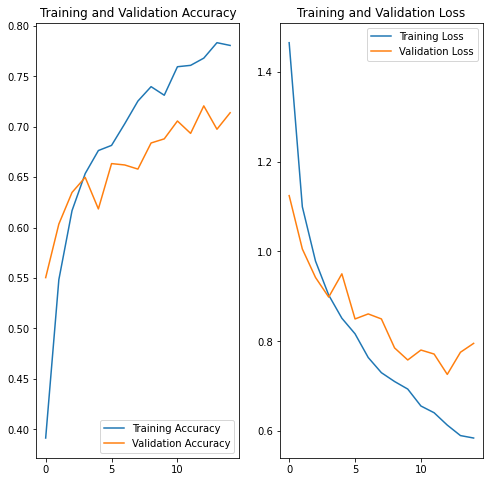

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
# 이미지 업로드 판별 

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to sunflowers with a 97.47 percent confidence.
